# Simple training on Iris dataset

In [3]:
from matrix_square_root_power import *
from shampoo_optimizer import *
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.1.0-rc1


## Loading data

In [4]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/daniil/.keras/datasets/iris_training.csv


In [5]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [6]:
train_dataset_fp

'/home/daniil/.keras/datasets/iris_training.csv'

In [7]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [8]:
train_dataset

<PrefetchDataset shapes: (OrderedDict([(sepal_length, (None,)), (sepal_width, (None,)), (petal_length, (None,)), (petal_width, (None,))]), (None,)), types: (OrderedDict([(sepal_length, tf.float32), (sepal_width, tf.float32), (petal_length, tf.float32), (petal_width, tf.float32)]), tf.int32)>

In [9]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([5.7, 6.1, 5. , 6. , 5.1, 5. , 4.5, 5.5, 5.3, 5. , 5.5, 4.9, 5.2,
       6.3, 4.6, 5.7, 6.2, 6.6, 6.1, 6.8, 5.2, 6.6, 6.4, 5.7, 4.7, 5.4,
       4.6, 6.3, 6.5, 6.9, 7.7, 6.3], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([2.8, 2.9, 3.6, 2.9, 2.5, 3.5, 2.3, 3.5, 3.7, 2.3, 2.6, 3.1, 3.4,
       2.7, 3.1, 4.4, 2.8, 3. , 2.6, 3. , 2.7, 2.9, 2.8, 3. , 3.2, 3.9,
       3.2, 2.3, 3. , 3.1, 2.6, 2.5], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([4.5, 4.7, 1.4, 4.5, 3. , 1.6, 1.3, 1.3, 1.5, 3.3, 4.4, 1.5, 1.4,
       4.9, 1.5, 1.5, 4.8, 4.4, 5.6, 5.5, 3.9, 4.6, 5.6, 4.2, 1.6, 1.7,
       1.4, 4.4, 5.5, 4.9, 6.9, 5. ], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.3, 1.4, 0.2, 1.5, 1.1, 0.6, 0.3, 0.2, 0.2, 1. , 1.2, 0.1, 0.2,
       1.8, 0.2, 0.4, 1.8, 1.4, 1.4, 2.1, 1.4, 1.3, 2.1, 1.2,

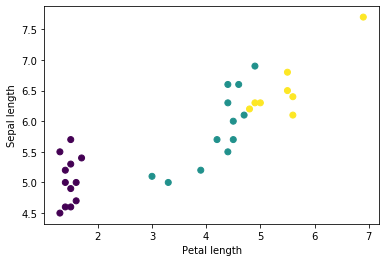

In [10]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [11]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [12]:
train_dataset = train_dataset.map(pack_features_vector)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'defaults'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'defaults'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'defaults'


In [13]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[5.4 3.4 1.5 0.4]
 [4.8 3.1 1.6 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [6.1 2.9 4.7 1.4]], shape=(5, 4), dtype=float32)


In [14]:
features.shape

TensorShape([32, 4])

In [15]:
def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

# Training loop

In [16]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = ShampooOptimizer(learning_rate=0.1, epsilon=1e-4)

shampoo_train_loss_results = []
shampoo_train_accuracy_results = []

num_epochs = 51

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  i = 0
  for x, y in train_dataset:
    i += 1
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))
  print(i)

  # End epoch
  shampoo_train_loss_results.append(epoch_loss_avg.result())
  shampoo_train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


4
Epoch 000: Loss: 1.159, Accuracy: 64.167%
4
Epoch 001: Loss: 0.558, Accuracy: 76.667%
4
Epoch 002: Loss: 0.501, Accuracy: 75.000%
4
Epoch 003: Loss: 0.495, Accuracy: 84.167%
4
Epoch 004: Loss: 0.368, Accuracy: 81.667%
4
Epoch 005: Loss: 0.292, Accuracy: 93.333%
4
Epoch 006: Loss: 0.365, Accuracy: 81.667%
4
Epoch 007: Loss: 0.313, Accuracy: 90.000%
4
Epoch 008: Loss: 0.225, Accuracy: 97.500%
4
Epoch 009: Loss: 0.225, Accuracy: 94.167%
4
Epoch 010: Loss: 0.178, Accuracy: 98.333%
4
Epoch 011: Loss: 0.272, Accuracy: 88.333%
4
Epoch 012: Loss: 0.229, Accuracy: 95.000%
4
Epoch 013: Loss: 0.230, Accuracy: 92.500%
4
Epoch 014: Loss: 0.178, Accuracy: 98.333%
4
Epoch 015: Loss: 0.187, Accuracy: 95.000%
4
Epoch 016: Loss: 0.136, Accuracy: 98.333%
4
Epoch 017: Loss: 0.195, Accuracy: 94.167%
4
Epoch 018: Loss: 0.240, Accuracy: 96.667%
4
Epoch 019: Loss: 0.188, Accuracy: 95.833%
4
Epoch 020: Loss: 0.137, Accuracy: 98.333%
4
Epoch 021: Loss: 0.106, Accuracy: 99.167%
4
Epoch 022: Loss: 0.120, Accura

In [17]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = ShampooOptimizer(learning_rate=0.1, epsilon=1e-3)

shampoo_train_loss_results_eps_1_e_3 = []
shampoo_train_accuracy_results_eps_1_e_3 = []

num_epochs = 51

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  i = 0
  for x, y in train_dataset:
    i += 1
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))
  print(i)

  # End epoch
  shampoo_train_loss_results_eps_1_e_3.append(epoch_loss_avg.result())
  shampoo_train_accuracy_results_eps_1_e_3.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

4
Epoch 000: Loss: 1.214, Accuracy: 48.333%
4
Epoch 001: Loss: 0.865, Accuracy: 70.000%
4
Epoch 002: Loss: 0.637, Accuracy: 73.333%
4
Epoch 003: Loss: 0.525, Accuracy: 73.333%
4
Epoch 004: Loss: 0.421, Accuracy: 84.167%
4
Epoch 005: Loss: 0.465, Accuracy: 82.500%
4
Epoch 006: Loss: 0.377, Accuracy: 84.167%
4
Epoch 007: Loss: 0.395, Accuracy: 88.333%
4
Epoch 008: Loss: 0.278, Accuracy: 83.333%
4
Epoch 009: Loss: 0.455, Accuracy: 88.333%
4
Epoch 010: Loss: 0.261, Accuracy: 95.000%
4
Epoch 011: Loss: 0.228, Accuracy: 96.667%
4
Epoch 012: Loss: 0.231, Accuracy: 92.500%
4
Epoch 013: Loss: 0.222, Accuracy: 93.333%
4
Epoch 014: Loss: 0.184, Accuracy: 96.667%
4
Epoch 015: Loss: 0.174, Accuracy: 96.667%
4
Epoch 016: Loss: 0.197, Accuracy: 93.333%
4
Epoch 017: Loss: 0.241, Accuracy: 91.667%
4
Epoch 018: Loss: 0.166, Accuracy: 95.833%
4
Epoch 019: Loss: 0.149, Accuracy: 95.000%
4
Epoch 020: Loss: 0.162, Accuracy: 93.333%
4
Epoch 021: Loss: 0.133, Accuracy: 96.667%
4
Epoch 022: Loss: 0.126, Accura

In [18]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = ShampooOptimizer(learning_rate=0.1, epsilon=1e-5)

shampoo_train_loss_results_eps_1_e_5 = []
shampoo_train_accuracy_results_eps_1_e_5 = []

num_epochs = 51

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  i = 0
  for x, y in train_dataset:
    i += 1
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))
  print(i)

  # End epoch
  shampoo_train_loss_results_eps_1_e_5.append(epoch_loss_avg.result())
  shampoo_train_accuracy_results_eps_1_e_5.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

4
Epoch 000: Loss: 0.788, Accuracy: 67.500%
4
Epoch 001: Loss: 0.617, Accuracy: 78.333%
4
Epoch 002: Loss: 0.405, Accuracy: 83.333%
4
Epoch 003: Loss: 0.370, Accuracy: 85.000%
4
Epoch 004: Loss: 0.412, Accuracy: 84.167%
4
Epoch 005: Loss: 0.278, Accuracy: 96.667%
4
Epoch 006: Loss: 0.370, Accuracy: 87.500%
4
Epoch 007: Loss: 0.221, Accuracy: 97.500%
4
Epoch 008: Loss: 0.204, Accuracy: 95.833%
4
Epoch 009: Loss: 0.181, Accuracy: 98.333%
4
Epoch 010: Loss: 0.158, Accuracy: 98.333%
4
Epoch 011: Loss: 0.196, Accuracy: 93.333%
4
Epoch 012: Loss: 0.148, Accuracy: 97.500%
4
Epoch 013: Loss: 0.123, Accuracy: 99.167%
4
Epoch 014: Loss: 0.134, Accuracy: 96.667%
4
Epoch 015: Loss: 0.130, Accuracy: 94.167%
4
Epoch 016: Loss: 0.200, Accuracy: 95.000%
4
Epoch 017: Loss: 0.103, Accuracy: 97.500%
4
Epoch 018: Loss: 0.141, Accuracy: 97.500%
4
Epoch 019: Loss: 0.120, Accuracy: 99.167%
4
Epoch 020: Loss: 0.093, Accuracy: 97.500%
4
Epoch 021: Loss: 0.087, Accuracy: 98.333%
4
Epoch 022: Loss: 0.097, Accura

In [19]:
epoch_loss_avg.result().numpy()

0.06469962

In [29]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

sgd_train_loss_results = []
sgd_train_accuracy_results = []

num_epochs = 51

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # End epoch
  sgd_train_loss_results.append(epoch_loss_avg.result())
  sgd_train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.299, Accuracy: 69.167%
Epoch 001: Loss: 0.562, Accuracy: 80.833%
Epoch 002: Loss: 0.458, Accuracy: 75.833%
Epoch 003: Loss: 0.445, Accuracy: 85.000%
Epoch 004: Loss: 0.415, Accuracy: 85.833%
Epoch 005: Loss: 0.450, Accuracy: 79.167%
Epoch 006: Loss: 0.407, Accuracy: 80.000%
Epoch 007: Loss: 0.457, Accuracy: 78.333%
Epoch 008: Loss: 0.405, Accuracy: 90.833%
Epoch 009: Loss: 0.347, Accuracy: 85.000%
Epoch 010: Loss: 0.424, Accuracy: 75.000%
Epoch 011: Loss: 0.485, Accuracy: 80.833%
Epoch 012: Loss: 0.320, Accuracy: 91.667%
Epoch 013: Loss: 0.372, Accuracy: 76.667%
Epoch 014: Loss: 0.412, Accuracy: 74.167%
Epoch 015: Loss: 0.339, Accuracy: 90.000%
Epoch 016: Loss: 0.268, Accuracy: 90.833%
Epoch 017: Loss: 0.235, Accuracy: 95.000%
Epoch 018: Loss: 0.555, Accuracy: 75.000%
Epoch 019: Loss: 0.289, Accuracy: 92.500%
Epoch 020: Loss: 0.428, Accuracy: 83.333%
Epoch 021: Loss: 0.289, Accuracy: 90.833%
Epoch 022: Loss: 0.819, Accuracy: 72.500%
Epoch 023: Loss: 0.436, Accuracy: 

In [21]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

adam_train_loss_results = []
adam_train_accuracy_results = []

num_epochs = 51

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # End epoch
  adam_train_loss_results.append(epoch_loss_avg.result())
  adam_train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.821, Accuracy: 35.000%
Epoch 001: Loss: 1.699, Accuracy: 35.000%
Epoch 002: Loss: 1.164, Accuracy: 40.833%
Epoch 003: Loss: 1.003, Accuracy: 52.500%
Epoch 004: Loss: 0.992, Accuracy: 35.000%
Epoch 005: Loss: 1.004, Accuracy: 35.000%
Epoch 006: Loss: 0.997, Accuracy: 35.000%
Epoch 007: Loss: 0.970, Accuracy: 35.000%
Epoch 008: Loss: 0.925, Accuracy: 35.833%
Epoch 009: Loss: 0.882, Accuracy: 60.833%
Epoch 010: Loss: 0.799, Accuracy: 70.000%
Epoch 011: Loss: 0.714, Accuracy: 70.000%
Epoch 012: Loss: 0.649, Accuracy: 70.000%
Epoch 013: Loss: 0.587, Accuracy: 70.000%
Epoch 014: Loss: 0.540, Accuracy: 70.000%
Epoch 015: Loss: 0.498, Accuracy: 70.000%
Epoch 016: Loss: 0.464, Accuracy: 70.000%
Epoch 017: Loss: 0.438, Accuracy: 75.000%
Epoch 018: Loss: 0.402, Accuracy: 85.833%
Epoch 019: Loss: 0.377, Accuracy: 94.167%
Epoch 020: Loss: 0.353, Accuracy: 95.000%
Epoch 021: Loss: 0.333, Accuracy: 95.833%
Epoch 022: Loss: 0.305, Accuracy: 95.833%
Epoch 023: Loss: 0.289, Accuracy: 

In [22]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

adam_train_loss_results_lr_1_e_1 = []
adam_train_accuracy_results_lr_1_e_1 = []

num_epochs = 51

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # End epoch
  adam_train_loss_results_lr_1_e_1.append(epoch_loss_avg.result())
  adam_train_accuracy_results_lr_1_e_1.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.495, Accuracy: 45.833%
Epoch 001: Loss: 0.840, Accuracy: 65.000%
Epoch 002: Loss: 0.532, Accuracy: 72.500%
Epoch 003: Loss: 0.482, Accuracy: 65.000%
Epoch 004: Loss: 0.430, Accuracy: 75.000%
Epoch 005: Loss: 0.453, Accuracy: 70.000%
Epoch 006: Loss: 0.438, Accuracy: 74.167%
Epoch 007: Loss: 0.422, Accuracy: 73.333%
Epoch 008: Loss: 0.420, Accuracy: 83.333%
Epoch 009: Loss: 0.397, Accuracy: 83.333%
Epoch 010: Loss: 0.407, Accuracy: 71.667%
Epoch 011: Loss: 0.436, Accuracy: 74.167%
Epoch 012: Loss: 0.398, Accuracy: 77.500%
Epoch 013: Loss: 0.374, Accuracy: 84.167%
Epoch 014: Loss: 0.367, Accuracy: 79.167%
Epoch 015: Loss: 0.333, Accuracy: 87.500%
Epoch 016: Loss: 0.291, Accuracy: 87.500%
Epoch 017: Loss: 0.225, Accuracy: 93.333%
Epoch 018: Loss: 0.214, Accuracy: 91.667%
Epoch 019: Loss: 0.136, Accuracy: 94.167%
Epoch 020: Loss: 0.099, Accuracy: 97.500%
Epoch 021: Loss: 0.100, Accuracy: 95.833%
Epoch 022: Loss: 0.090, Accuracy: 97.500%
Epoch 023: Loss: 0.160, Accuracy: 

# Plotting graphs

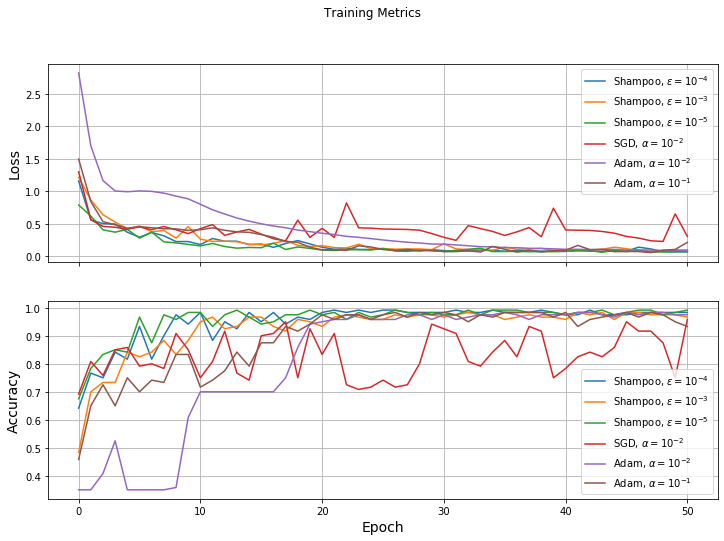

In [31]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(shampoo_train_loss_results, label = r"Shampoo, $\varepsilon = 10^{-4}$")
axes[0].plot(shampoo_train_loss_results_eps_1_e_3, label = r"Shampoo, $\varepsilon = 10^{-3}$")
axes[0].plot(shampoo_train_loss_results_eps_1_e_5, label = r"Shampoo, $\varepsilon = 10^{-5}$")
axes[0].plot(sgd_train_loss_results, label = r"SGD, $\alpha = 10^{-2}$")
axes[0].plot(adam_train_loss_results, label = r"Adam, $\alpha = 10^{-2}$")
axes[0].plot(adam_train_loss_results_lr_1_e_1, label = r"Adam, $\alpha = 10^{-1}$")
axes[0].grid()
axes[0].legend()

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(shampoo_train_accuracy_results, label = r"Shampoo, $\varepsilon = 10^{-4}$")
axes[1].plot(shampoo_train_accuracy_results_eps_1_e_3, label = r"Shampoo, $\varepsilon = 10^{-3}$")
axes[1].plot(shampoo_train_accuracy_results_eps_1_e_5, label = r"Shampoo, $\varepsilon = 10^{-5}$")
axes[1].plot(sgd_train_accuracy_results, label = r"SGD, $\alpha = 10^{-2}$")
axes[1].plot(adam_train_accuracy_results, label = r"Adam, $\alpha = 10^{-2}$")
axes[1].plot(adam_train_accuracy_results_lr_1_e_1, label = r"Adam, $\alpha = 10^{-1}$")
axes[1].grid()
axes[1].legend()
plt.show()